In [1]:
from rmgpy.cantherm import CanTherm, KineticsJob, StatMechJob
from rmgpy.cantherm import *
from autotst.reaction import *

In [2]:
reactants = [Molecule(SMILES="CC=C(C)C"), Molecule(SMILES="[O]O")]
products = [Molecule(SMILES="[CH2]C=C(C)C"), Molecule(SMILES="OO")]
rmg_reaction = Reaction(reactants=reactants, products=products)

rxn = AutoTST_Reaction(reaction_family="H_Abstraction", rmg_reaction=rmg_reaction)


thermo.py:839 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:856 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-Py/../RMG-database/input/transport/groups...
database.py:167 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG-Py/../RMG-database/input/kinetics/families
statmech.py:526 loadGroups INFO Loading frequencies group database from /Users/nathan/

## Writing the overall CanTherm file

In [3]:
def write_cantherm_ts(rxn):
    top = ["#!/usr/bin/env python", "# -*- coding: utf-8 -*-", "", 'modelChemistry = "M06-2X/cc-pVTZ"', "frequencyScaleFactor = 0.982", "useHinderedRotors = False", "useBondCorrections = False", ""]

    scratch ="."
    for react in rxn.reactant_mols:
        line = "species('{0}', '{1}')".format(react.smiles, os.path.join(scratch, react.smiles +".py"))
        top.append(line)

    for prod in rxn.product_mols:
        line = "species('{0}', '{1}')".format(prod.smiles, os.path.join(scratch, prod.smiles +".py"))
        top.append(line)

    line = "transitionState('TS', '{0}')".format(os.path.join(scratch, rxn.label +".py"))
    top.append(line)


    line = ["",
    "reaction(",
    "    label = '{0}',".format(rxn.label),
    "    reactants = ['{0}', '{1}'],".format(rxn.reactant_mols[0].smiles, rxn.reactant_mols[1].smiles),
    "    products = ['{0}', '{1}'],".format(rxn.product_mols[0].smiles, rxn.product_mols[1].smiles),
    "    transitionState = 'TS',",
    "    tunneling = 'Eckart',",
    ")",
    "",
    "statmech('TS')",
    "kinetics('{0}')".format(rxn.label)]
    top += line


    input_string = ""

    for t in top:
        input_string += t +"\n"

    with open(rxn.label +".cantherm.py", "w") as f:
        f.write(input_string)

In [4]:
def write_statmech_ts(rxn):
    output = ['#!/usr/bin/env python', '# -*- coding: utf-8 -*-', '', 'atoms = {']


    atom_dict = get_atoms(rxn)

    for atom, count in atom_dict.iteritems():
        output.append("    '{0}': {1},".format(atom, count))
    output = output + ['}', '']


    bond_dict = get_bonds(rxn)
    if bond_dict != {}:
        output.append('bonds = {')
        for bond_type, num in bond_dict.iteritems():
            output.append("    '{0}': {1},".format(bond_type, num))
            
        output.append("}")
    else:
        output.append('bonds = {}')



    output += ["","linear = False","","externalSymmetry = 1", "", "spinMultiplicity = {}".format(rxn.ts.rmg_ts.multiplicity), "", "opticalIsomers = 1", ""]

    output += ["energy = {","    'M06-2X/cc-pVTZ': GaussianLog('{}_overall.log'),".format(rxn.label),"}",""]

    output += ["geometry = GaussianLog('{}_overall.log')".format(rxn.label), ""]

    output += ["frequencies = GaussianLog('{}_overall.log')".format(rxn.label), ""]

    output += ["rotors = []", ""]

    input_string = ""

    for t in output:
        input_string += t +"\n"
    print input_string

    with open(os.path.join(rxn.label +".py"), "w") as f:
        f.write(input_string)

In [5]:
def write_cantherm_for_reacts_and_prods(mol):

    output = ['#!/usr/bin/env python', '# -*- coding: utf-8 -*-', '', 'atoms = {']
            
    atom_dict = get_atoms(mol)

    for atom, count in atom_dict.iteritems():
        output.append("    '{0}': {1},".format(atom, count))
    output = output + ['}', '']

    bond_dict = get_bonds(mol)
    if bond_dict != {}:
        output.append('bonds = {')
        for bond_type, num in bond_dict.iteritems():
            output.append("    '{0}': {1},".format(bond_type, num))
        output.append("}")
    else:
        output.append('bonds = {}')



    output += ["","linear = False","","externalSymmetry = 1", "", "spinMultiplicity = {}".format(mol.rmg_molecule.multiplicity), "", "opticalIsomers = 1", ""]

    output += ["energy = {","    'M06-2X/cc-pVTZ': GaussianLog('{}.log'),".format(mol.smiles),"}",""]

    output += ["geometry = GaussianLog('{}.log')".format(mol.smiles), ""]

    output += ["frequencies = GaussianLog('{}.log')".format(mol.smiles), ""]

    output += ["rotors = []"]

    input_string = ""

    for t in output:
        input_string += t +"\n"

    with open(os.path.join(mol.smiles+".py"), "w") as f:
        f.write(input_string)
        


In [6]:
def get_bonds(mol):
    bondList = []
    if isinstance(mol, AutoTST_Molecule):
        rmg_mol = mol.rmg_molecule
    elif isinstance(mol, AutoTST_Reaction):
        rmg_mol = mol.ts.rmg_ts
    elif isinstance(mol, AutoTST_TS):
        rmg_mol = mol.rmg_ts
    for atom in rmg_mol.atoms:
        for bond in atom.bonds.values():
            bondList.append(bond)
    bonds = list(set(bondList))
    bondDict = {}
    for bond in bonds:
        if bond.isSingle():
            if bond.atom1.symbol=='C' and bond.atom2.symbol=='C':
                bondType = 'C-C'
            elif (bond.atom1.symbol=='H' and bond.atom2.symbol=='H'):
                bondType = 'H-H'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='H') or (bond.atom1.symbol=='H' and bond.atom2.symbol=='C'):
                bondType = 'C-H'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='O'):
                bondType = 'O-O'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='O') or (bond.atom1.symbol=='O' and bond.atom2.symbol=='C'):
                bondType = 'C-O'
            elif (bond.atom1.symbol=='H' and bond.atom2.symbol=='O') or (bond.atom1.symbol=='O' and bond.atom2.symbol=='H'):
                bondType = 'O-H'
            elif bond.atom1.symbol=='N' and bond.atom2.symbol=='N':
                bondType = 'N-N'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='C'):
                bondType = 'N-C'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='O'):
                bondType = 'N-O'
            elif (bond.atom1.symbol=='H' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='H'):
                bondType = 'N-H'
            elif bond.atom1.symbol=='S' and bond.atom2.symbol=='S':
                bondType = 'S-S'
            elif (bond.atom1.symbol=='H' and bond.atom2.symbol=='S') or (bond.atom1.symbol=='S' and bond.atom2.symbol=='H'):
                bondType = 'S-H'
        elif bond.isDouble:
            if bond.atom1.symbol=='C' and bond.atom2.symbol=='C':
                bondType = 'C=C'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='O'):
                bondType = 'O=O'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='O') or (bond.atom1.symbol=='O' and bond.atom2.symbol=='C'):
                bondType = 'C=O'
            elif bond.atom1.symbol=='N' and bond.atom2.symbol=='N':
                bondType = 'N=N'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='C'):
                bondType = 'N=C'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='O'):
                bondType = 'N=O'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='S') or (bond.atom1.symbol=='S' and bond.atom2.symbol=='O'):
                bondType = 'S=O'
        elif bond.isTriple:
            if bond.atom1.symbol=='C' and bond.atom2.symbol=='C':
                bondType = 'C#C'
            elif bond.atom1.symbol=='N' and bond.atom2.symbol=='N':
                bondType = 'N#N'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='C'):
                bondType = 'N#C'
        try:
            bondDict[bondType] += 1
        except KeyError:
            bondDict[bondType] = 1

    return bondDict

In [7]:
def get_atoms(mol):
    atom_dict={}
    if isinstance(mol, AutoTST_Molecule):
        rmg_mol = mol.rmg_molecule
    elif isinstance(mol, AutoTST_Reaction):
        rmg_mol = mol.ts.rmg_ts
    elif isinstance(mol, AutoTST_TS):
        rmg_mol = mol.rmg_ts
    for atom in rmg_mol.atoms:
        if atom.isCarbon():
            atom_type = "C"
        if atom.isHydrogen():
            atom_type = "H"
        if atom.isOxygen():
            atom_type = "O"

        try:
            atom_dict[atom_type] += 1
        except KeyError:
            atom_dict[atom_type] = 1
            
    return atom_dict

In [8]:
for mol in rxn.reactant_mols:
    write_cantherm_for_reacts_and_prods(mol)
    
for mol in rxn.product_mols:
    write_cantherm_for_reacts_and_prods(mol)
    
write_statmech_ts(rxn)

write_cantherm_ts(rxn)

#!/usr/bin/env python
# -*- coding: utf-8 -*-

atoms = {
    'H': 11,
    'C': 5,
    'O': 2,
}

bonds = {
    'O-O': 1,
    'C=C': 1,
    'O-H': 1,
    'C-C': 3,
    'C-H': 10,
}

linear = False

externalSymmetry = 1

spinMultiplicity = 2

opticalIsomers = 1

energy = {
    'M06-2X/cc-pVTZ': GaussianLog('CC=C(C)C+[O]O_[CH2]C=C(C)C+OO_overall.log'),
}

geometry = GaussianLog('CC=C(C)C+[O]O_[CH2]C=C(C)C+OO_overall.log')

frequencies = GaussianLog('CC=C(C)C+[O]O_[CH2]C=C(C)C+OO_overall.log')

rotors = []




In [9]:
cantherm_job = CanTherm()
cantherm_job.inputFile = rxn.label + ".cantherm.py"
cantherm_job.plot = False
cantherm_job.outputDirectory = "."

cantherm_job.execute()

CanTherm execution initiated at Tue May  8 20:00:56 2018

###############################################################
#                                                             #
#                          CanTherm                           #
#                                                             #
#   Version: 2.1.0                                            #
#   Authors: RMG Developers (rmg_dev@mit.edu)                 #
#   P.I.s:   William H. Green (whgreen@mit.edu)               #
#            Richard H. West (r.west@neu.edu)                 #
#   Website: http://reactionmechanismgenerator.github.io/     #
#                                                             #
###############################################################

Loading species CC=C(C)C...
Loading species [O]O...
Loading species [CH2]C=C(C)C...
Loading species OO...
Loading transition state TS...
Loading reaction CC=C(C)C+[O]O_[CH2]C=C(C)C+OO...


Loading statistical mechanics parameters for CC=

/Users/nathan/Code/RMG-Py/rmgpy/cantherm/kinetics.py:166: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.reaction.kinetics = Arrhenius().fitToData(Tlist, klist, kunits=self.kunits)



CanTherm execution terminated at Tue May  8 20:00:58 2018


/Users/nathan/Code/RMG-Py/rmgpy/cantherm/kinetics.py:228: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  kinetics0rev = Arrhenius().fitToData(Tlist, numpy.array(k0revs), kunits=self.krunits)
/Users/nathan/Code/RMG-Py/rmgpy/cantherm/kinetics.py:229: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  kineticsrev = Arrhenius().fitToData(Tlist, numpy.array(krevs), kunits=self.krunits)


In [10]:
for job in cantherm_job.jobList:
    if isinstance(job, KineticsJob):
        break

In [11]:
for reactant in rxn.rmg_reaction.reactants:
    for r in job.reaction.reactants: 
        if reactant.toSMILES() == r.label:
            r.molecule = [reactant]
            
for product in rxn.rmg_reaction.products:
    for p in job.reaction.products: 
        if product.toSMILES() == p.label:
            p.molecule = [product]

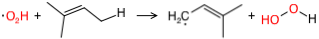

In [12]:
job.reaction

In [13]:
print "{0!r}".format(job.reaction)

Reaction(label='CC=C(C)C+[O]O_[CH2]C=C(C)C+OO', reactants=[Species(label="[O]O", conformer=Conformer(E0=(1936.47,'kJ/mol'), modes=[IdealGasTranslation(mass=(32.9977,'amu')), NonlinearRotor(inertia=([0.775043,14.5598,15.3349],'amu*angstrom^2'), symmetry=1), HarmonicOscillator(frequencies=([1228.4,1593.69,3942.52],'cm^-1'))], spinMultiplicity=2), molecule=[Molecule(SMILES="[O]O")]), Species(label="CC=C(C)C", conformer=Conformer(E0=(3546.66,'kJ/mol'), modes=[IdealGasTranslation(mass=(70.0782,'amu')), NonlinearRotor(inertia=([62.5929,143.621,196.994],'amu*angstrom^2'), symmetry=1), HarmonicOscillator(frequencies=([117.231,134.704,189.224,278.553,313.164,403.088,485.653,549.797,803.349,902.596,1017.95,1032.88,1098.3,1139.51,1155.72,1194.66,1205.24,1318.16,1476.87,1538.13,1541.56,1551.02,1589.96,1601.1,1601.23,1609.84,1615.09,1615.76,1881.78,3127.87,3135.15,3138.61,3169.45,3175.38,3176.31,3218.89,3231.29,3253.11,3261.32],'cm^-1'))]), molecule=[Molecule(SMILES="CC=C(C)C")])], products=[Specie

In [14]:
from autotst.calculators.cantherm import *

In [15]:
calc = AutoTST_CanTherm(rxn)

In [16]:
calc.write_files()

In [17]:
calc.run()

CanTherm execution initiated at Tue May  8 20:00:59 2018

###############################################################
#                                                             #
#                          CanTherm                           #
#                                                             #
#   Version: 2.1.0                                            #
#   Authors: RMG Developers (rmg_dev@mit.edu)                 #
#   P.I.s:   William H. Green (whgreen@mit.edu)               #
#            Richard H. West (r.west@neu.edu)                 #
#   Website: http://reactionmechanismgenerator.github.io/     #
#                                                             #
###############################################################

Loading species CC=C(C)C...
Loading species [O]O...
Loading species [CH2]C=C(C)C...
Loading species OO...
Loading transition state TS...
Loading reaction CC=C(C)C+[O]O_[CH2]C=C(C)C+OO...


Loading statistical mechanics parameters for CC=

In [18]:
calc.set_reactants_and_products()

<AutoTST Reaction "CC=C(C)C+[O]O_[CH2]C=C(C)C+OO">

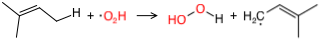

In [19]:
calc.kinetics_job.reaction

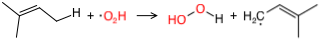

In [20]:
rxn.rmg_reaction

In [21]:
rxn.reactant_mols[0]

<AutoTST Molecule "CC=C(C)C">

In [22]:
df = [[1,2,3,4],
      [2,3,4,5],
      [4,5,3,6],
      [-4,-6,-9,-10]]

df = -1 * pd.DataFrame(df)
df

,0,1,2,3
0,-1,-2,-3,-4
1,-2,-3,-4,-5
2,-4,-5,-3,-6
3,4,6,9,10


In [23]:
t = df.describe()
t

,0,1,2,3
count,4.00000,4.000000,4.000000,4.000000
mean,-0.75000,-1.000000,-0.250000,-1.250000
std,3.40343,4.830459,6.184658,7.544314
min,-4.00000,-5.000000,-4.000000,-6.000000
25%,-2.50000,-3.500000,-3.250000,-5.250000
50%,-1.50000,-2.500000,-3.000000,-4.500000
75%,0.25000,0.000000,0.000000,-0.500000
max,4.00000,6.000000,9.000000,10.000000


In [24]:
t.loc["std"][0] / abs(t.loc["max"][0] - t.loc["min"][0])

0.42542870534712784

In [25]:
-3 - (-5)

2

In [26]:
for a in rxn.ts.rmg_ts.atoms:
    print len(a.label)

2
0
0
0
2
0
0
0
0
2
0
0
0
0
0
0
0
0


In [27]:
from autotst.calculators.gaussian import *

In [28]:
calc = AutoTST_Gaussian(rxn)
calc

<AutoTST Gaussian Calculators "CC=C(C)C+[O]O_[CH2]C=C(C)C+OO">

In [29]:
string = calc.center_calc.addsec[0]
string

'2 3 F\n2 4 F\n2 6 F\n2 7 F\n2 8 F\n2 9 F\n2 11 F\n2 12 F\n2 13 F\n2 14 F\n2 15 F\n2 16 F\n2 17 F\n2 18 F\n3 4 F\n3 6 F\n3 7 F\n3 8 F\n3 9 F\n3 11 F\n3 12 F\n3 13 F\n3 14 F\n3 15 F\n3 16 F\n3 17 F\n3 18 F\n4 6 F\n4 7 F\n4 8 F\n4 9 F\n4 11 F\n4 12 F\n4 13 F\n4 14 F\n4 15 F\n4 16 F\n4 17 F\n4 18 F\n6 7 F\n6 8 F\n6 9 F\n6 11 F\n6 12 F\n6 13 F\n6 14 F\n6 15 F\n6 16 F\n6 17 F\n6 18 F\n7 8 F\n7 9 F\n7 11 F\n7 12 F\n7 13 F\n7 14 F\n7 15 F\n7 16 F\n7 17 F\n7 18 F\n8 9 F\n8 11 F\n8 12 F\n8 13 F\n8 14 F\n8 15 F\n8 16 F\n8 17 F\n8 18 F\n9 11 F\n9 12 F\n9 13 F\n9 14 F\n9 15 F\n9 16 F\n9 17 F\n9 18 F\n11 12 F\n11 13 F\n11 14 F\n11 15 F\n11 16 F\n11 17 F\n11 18 F\n12 13 F\n12 14 F\n12 15 F\n12 16 F\n12 17 F\n12 18 F\n13 14 F\n13 15 F\n13 16 F\n13 17 F\n13 18 F\n14 15 F\n14 16 F\n14 17 F\n14 18 F\n15 16 F\n15 17 F\n15 18 F\n16 17 F\n16 18 F\n17 18 F'

In [30]:
indicies = []
for i, atom in enumerate(rxn.ts.rmg_ts.atoms):
    if len(atom.label) == 0:
        indicies.append(i)
        
indicies

[1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17]

In [31]:
combos = ""
for combo in list(itertools.combinations(indicies, 2)):
    a,b = combo
    combos += "{0} {1} F\n".format(a+1,b+1)
    
print combos

2 3 F
2 4 F
2 6 F
2 7 F
2 8 F
2 9 F
2 11 F
2 12 F
2 13 F
2 14 F
2 15 F
2 16 F
2 17 F
2 18 F
3 4 F
3 6 F
3 7 F
3 8 F
3 9 F
3 11 F
3 12 F
3 13 F
3 14 F
3 15 F
3 16 F
3 17 F
3 18 F
4 6 F
4 7 F
4 8 F
4 9 F
4 11 F
4 12 F
4 13 F
4 14 F
4 15 F
4 16 F
4 17 F
4 18 F
6 7 F
6 8 F
6 9 F
6 11 F
6 12 F
6 13 F
6 14 F
6 15 F
6 16 F
6 17 F
6 18 F
7 8 F
7 9 F
7 11 F
7 12 F
7 13 F
7 14 F
7 15 F
7 16 F
7 17 F
7 18 F
8 9 F
8 11 F
8 12 F
8 13 F
8 14 F
8 15 F
8 16 F
8 17 F
8 18 F
9 11 F
9 12 F
9 13 F
9 14 F
9 15 F
9 16 F
9 17 F
9 18 F
11 12 F
11 13 F
11 14 F
11 15 F
11 16 F
11 17 F
11 18 F
12 13 F
12 14 F
12 15 F
12 16 F
12 17 F
12 18 F
13 14 F
13 15 F
13 16 F
13 17 F
13 18 F
14 15 F
14 16 F
14 17 F
14 18 F
15 16 F
15 17 F
15 18 F
16 17 F
16 18 F
17 18 F



In [32]:
combos == string

False

In [33]:
len(string.split("\n"))

105

In [34]:
len(combos.split("\n"))

106

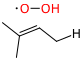

In [35]:
test  = rxn.ts.rmg_ts
test

In [36]:
labeled_atoms = []
non_labeled_atoms = range(1, len(test.atoms)+1)
for atom in test.getLabeledAtoms().values():
    labeled_atoms.append(atom.sortingLabel + 1)
    non_labeled_atoms.remove(atom.sortingLabel +1)
non_labeled_atoms

[2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]

In [37]:
labeled_atoms = []
r = range(len(test.atoms))
for atom in test.getLabeledAtoms().values():
    labeled_atoms.append(atom.sortingLabel)
labeled_atoms

[4, 9, 0]

In [38]:
for combo in itertools.combinations(non_labeled_atoms, 2):
    print combo

(2, 3)
(2, 4)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(3, 4)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(3, 16)
(3, 17)
(3, 18)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 11)
(4, 12)
(4, 13)
(4, 14)
(4, 15)
(4, 16)
(4, 17)
(4, 18)
(6, 7)
(6, 8)
(6, 9)
(6, 11)
(6, 12)
(6, 13)
(6, 14)
(6, 15)
(6, 16)
(6, 17)
(6, 18)
(7, 8)
(7, 9)
(7, 11)
(7, 12)
(7, 13)
(7, 14)
(7, 15)
(7, 16)
(7, 17)
(7, 18)
(8, 9)
(8, 11)
(8, 12)
(8, 13)
(8, 14)
(8, 15)
(8, 16)
(8, 17)
(8, 18)
(9, 11)
(9, 12)
(9, 13)
(9, 14)
(9, 15)
(9, 16)
(9, 17)
(9, 18)
(11, 12)
(11, 13)
(11, 14)
(11, 15)
(11, 16)
(11, 17)
(11, 18)
(12, 13)
(12, 14)
(12, 15)
(12, 16)
(12, 17)
(12, 18)
(13, 14)
(13, 15)
(13, 16)
(13, 17)
(13, 18)
(14, 15)
(14, 16)
(14, 17)
(14, 18)
(15, 16)
(15, 17)
(15, 18)
(16, 17)
(16, 18)
(17, 18)


In [ ]:
len(list(itertools.combinations(range(len(test.atoms)), 2)))

In [ ]:
combos = []
for i in labeled_atoms:
    for j in labeled_atoms:
        if i == j:
            continue
        
        if (i,j) in combos or tuple(reversed((i,j))) in combos:
            continue
            
        combos.append((i,j))
        
combos

In [ ]:
combos = []
for i in non_labeled_atoms:
    for j in non_labeled_atoms:
        if i == j:
            continue
        
        if (i,j) in combos or tuple(reversed((i,j))) in combos:
            continue
            
        combos.append((i,j))
combos

In [ ]:
rxn = AutoTST_Reaction(reaction_family="H_Abstraction", rmg_reaction=rmg_reaction)

In [ ]:
rxn.ts.create_pseudo_geometry()

In [ ]:
logging.getLogger('rdkit').setLevel(logging.FATAL)

In [ ]:
m = rxn.ts.create_pseudo_geometry()
m.UpdatePropertyCache(strict=False)

In [41]:
calc.run_all()

RuntimeError: Gaussian in . returned an error: 127